### Learn $P(M_\star, z)$ from SEDFlow

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os, sys
import pickle
import corner
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.table import Table

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
import popsed
from popsed import prior
popsed.set_matplotlib(style='JL', usetex=False, dpi=80)

### Check Chang's combined posterior based on normalizing flow

In [36]:
sample = np.load('./nsa_sedflow/nsa_sedflow.posterior_combined.npy')
# redshift = f['redshift'][...]
redshift = sample[:, -1].astype(float)
sample = np.hstack([sample[:, 0:1], prior.FlatDirichletPrior(4).transform(sample[:, 1:4]), 
                    sample[:, 4:6], 10**sample[:, 6:8], sample[:, 8:-1]]) # not include redshift

In [37]:
# translate Chang's ZH to my Z
from popsed.models import NMF_ZH
nmf = NMF_ZH()
nmf._load_NMF_bases()

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [38]:
z_mw_list = [np.log10(nmf.Z_MW(sample[i], zred=redshift[i])) for i in range(10000)]

In [39]:
z_mw_list = np.array(z_mw_list).ravel() - (np.log10(0.0134)) # normalize by solar Z

In [40]:
sample = np.load('./nsa_sedflow/nsa_sedflow.posterior_combined.npy')
sample = np.hstack([prior.FlatDirichletPrior(4).transform(sample[:, 1:4]), 
                    sample[:, 4:6], z_mw_list[:, None], sample[:, 8:-1],
                    sample[:, -1:], sample[:, 0:1]])

In [41]:
sample.shape

(10000, 12)

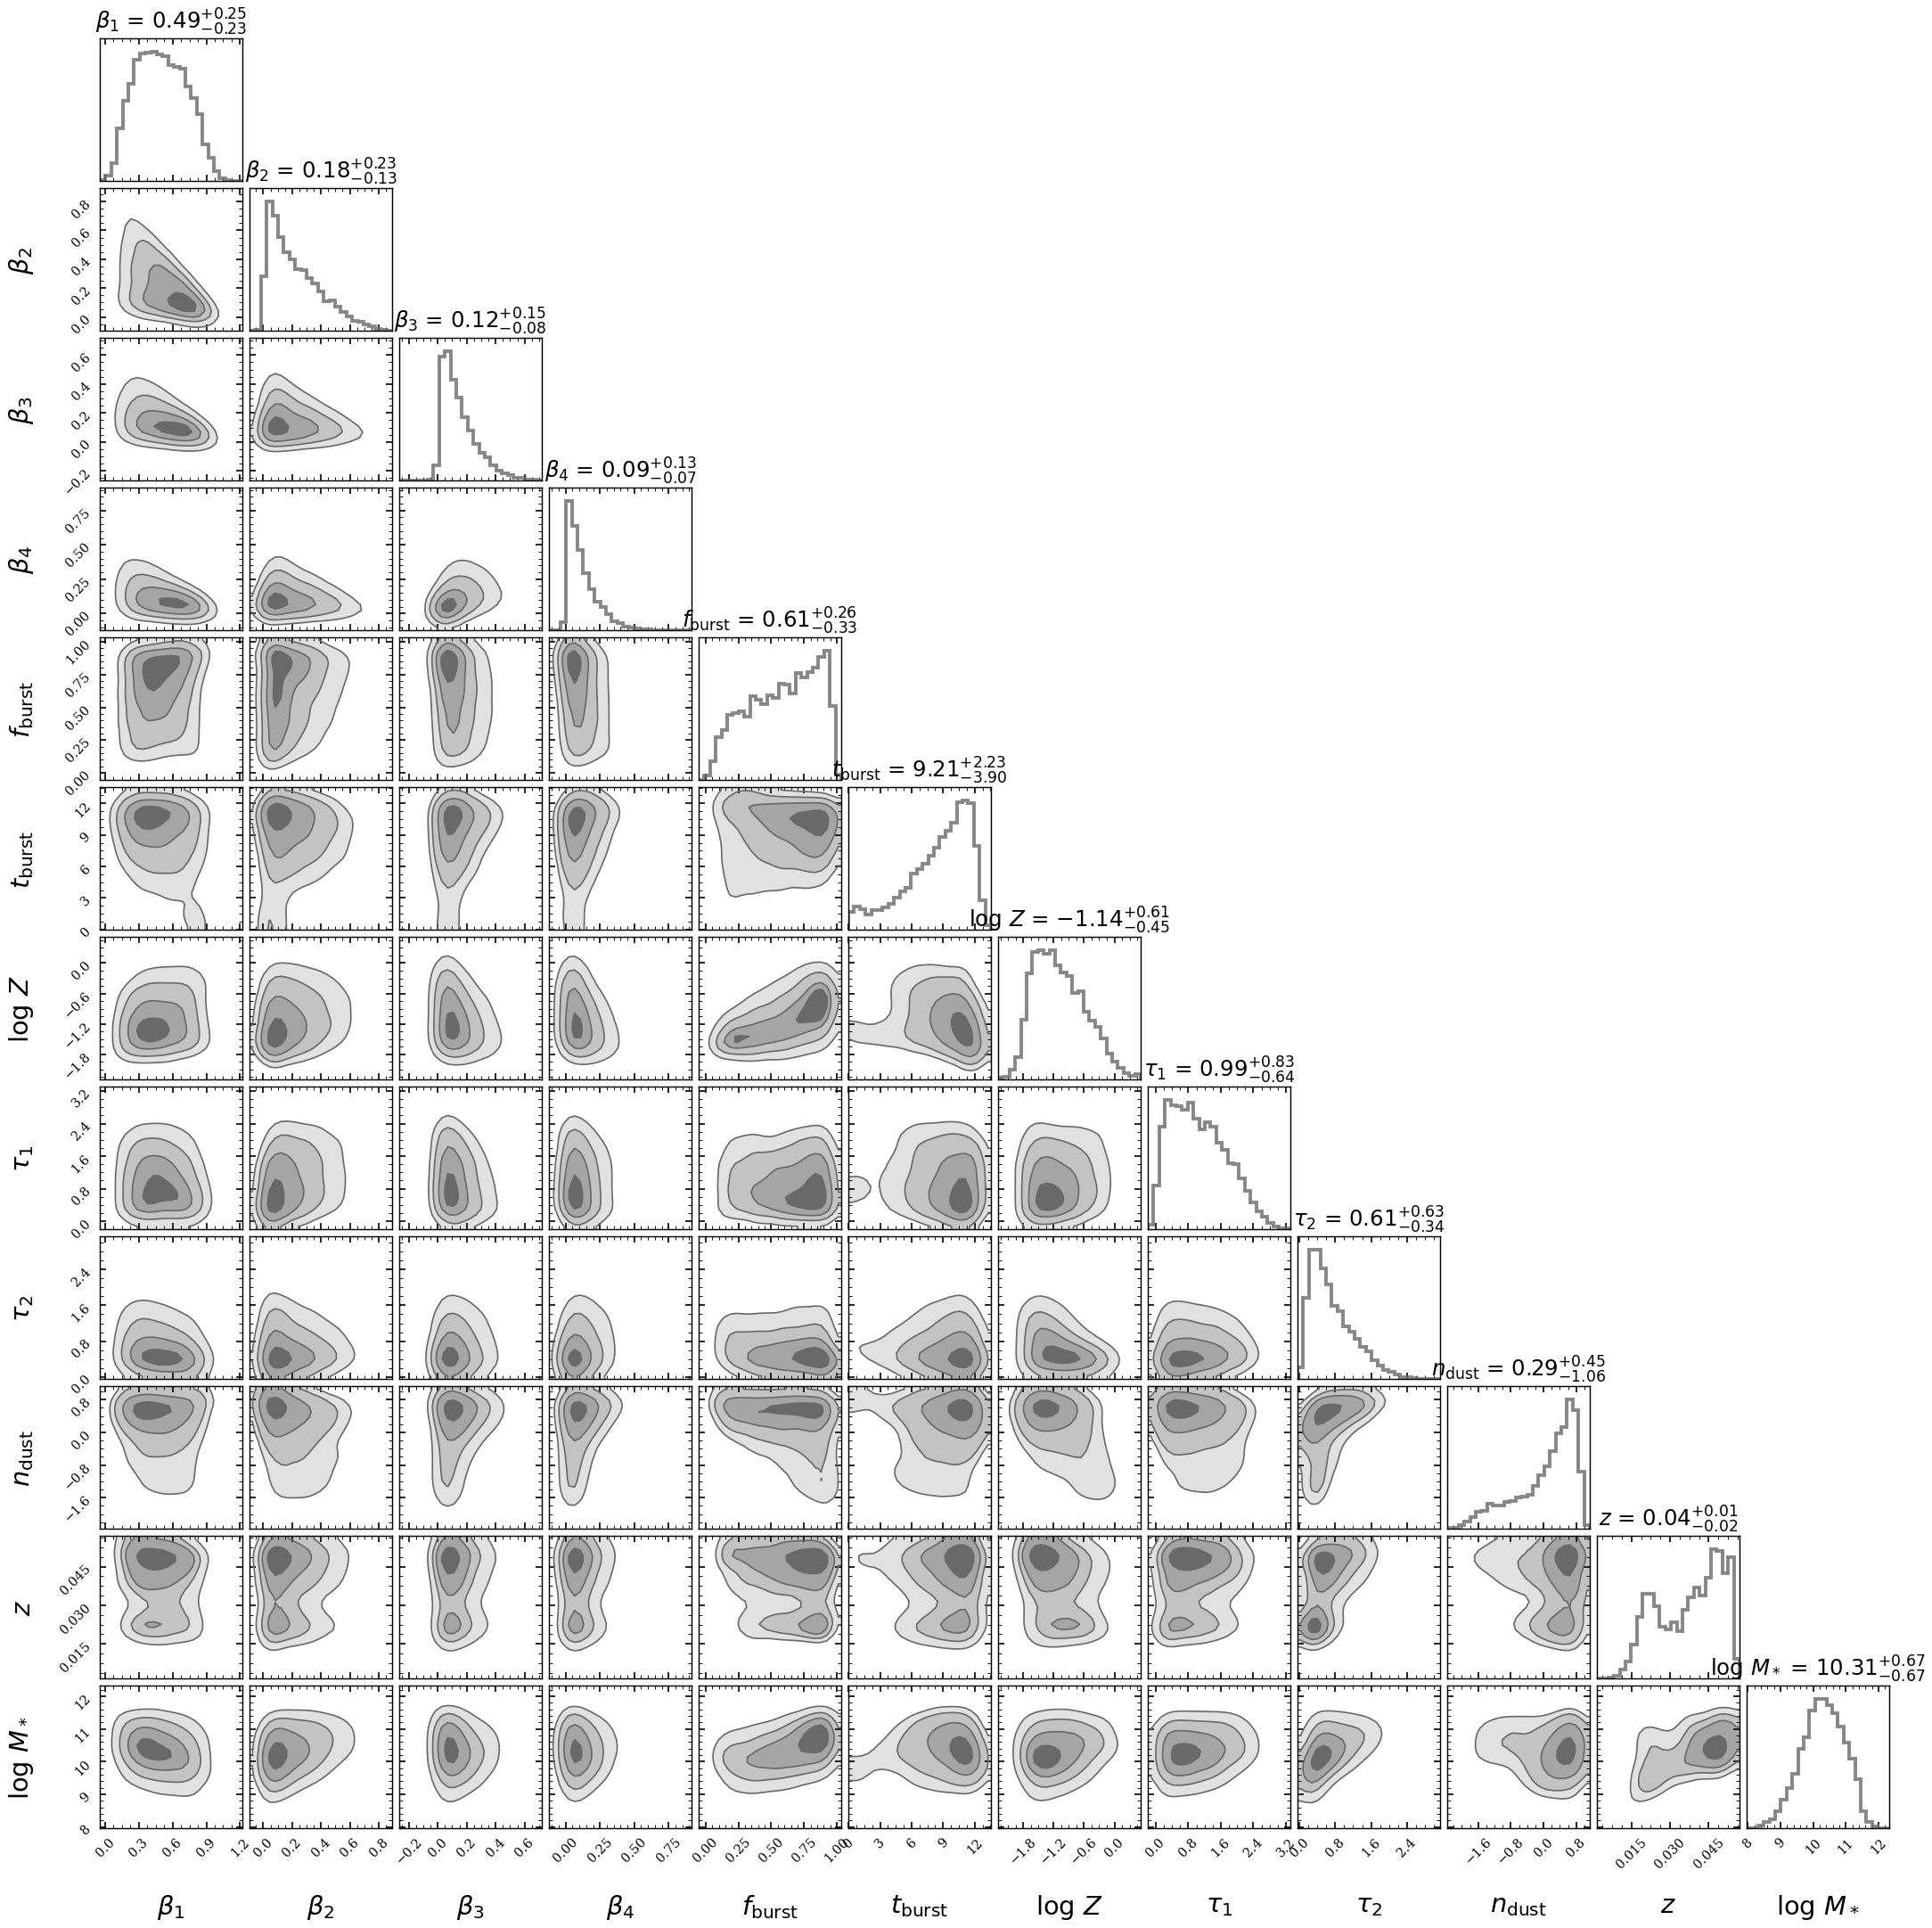

In [42]:
import matplotlib.lines as mlines

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

# figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    sample,
#     fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [43]:
np.save('./nsa_sedflow/nsa_sedflow.posterior.reorganized.npy', sample)

In [44]:
sample.shape

(10000, 12)

---

In [45]:
sample = np.load('./nsa_sedflow/nsa_sedflow.posterior.reorganized.npy')
sample.shape

(10000, 12)

### Learn $P(M_\star, z)$ from SEDFlow

In [4]:
import torch
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss
from tqdm import trange
from sklearn.model_selection import train_test_split

In [75]:
X_train = torch.Tensor(sample[:, -2:])
Y_train = torch.ones(len(X_train), 2)

In [5]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [89]:
transform_nmf_params(X_train, [[0, 0.06], [7, 13]])

tensor([[ 0.9565,  0.2476],
        [ 0.6054, -0.1428],
        [-0.0866, -0.0195],
        ...,
        [ 0.8288,  0.2324],
        [-0.1903, -0.1704],
        [ 0.7205, -0.0440]])

In [96]:
seed = 42
np.random.seed(seed)

_prior_NDE = [[0, 0.1], [7, 13]]

_bounds = np.array([[0.03, 0.03], [10, 10]])
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 30), 
                   np.abs(np.random.normal(size=len(_bounds)) / 30)]).T
_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=10,  # 10
                                              num_bins=15,  # how smashed it is. 10
                                              hidden_features=50,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=False, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )
NDE_theta.build(
    Y_train,
    X_train,
    optimizer='adam')

[-0.00226965  0.04803839]


In [97]:
train_loss_history = []
vali_loss_history = []
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3, #5e-4,
                                                steps_per_epoch=100,
                                                epochs=6)
for i, epoch in enumerate(range(6)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    
    t = trange(100,
           desc='Training NDE_theta using Wasserstein loss',
           unit='epochs')
    for epoch in t:
        NDE_theta.optimizer.zero_grad()
        _X_train, _X_vali = train_test_split(
            X_train.detach(), test_size=0.1, shuffle=True)
        
        loss = -NDE_theta.net.log_prob(transform_nmf_params(_X_train, _prior_NDE).to('cuda')).mean()
        loss.backward()
        NDE_theta.optimizer.step()
        train_loss_history.append(loss.item())
        
        vali_loss = -NDE_theta.net.log_prob(transform_nmf_params(_X_train, _prior_NDE).to('cuda')).mean()
        vali_loss_history.append(vali_loss.item())

        t.set_description(
            f'Loss = {loss.item():.3f} (train), {vali_loss.item():.3f} (vali)')
        
        scheduler.step()

    Epoch 0
    lr: 3.9999999999999996e-05


Loss = 0.296 (train), 0.286 (vali): 100%|████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76epochs/s]


    Epoch 1
    lr: 0.0006079561997114258


Loss = 0.078 (train), 0.079 (vali): 100%|████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79epochs/s]


    Epoch 2
    lr: 0.0009938441949208876


Loss = 0.065 (train), 0.068 (vali): 100%|████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76epochs/s]


    Epoch 3
    lr: 0.0008088129289961519


Loss = 0.061 (train), 0.060 (vali): 100%|████████████████████████████████████████████| 100/100 [00:14<00:00,  6.78epochs/s]


    Epoch 4
    lr: 0.00045890866416338575


Loss = 0.054 (train), 0.054 (vali): 100%|████████████████████████████████████████████| 100/100 [00:14<00:00,  6.78epochs/s]


    Epoch 5
    lr: 0.0001309439774943247


Loss = 0.059 (train), 0.059 (vali): 100%|████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72epochs/s]


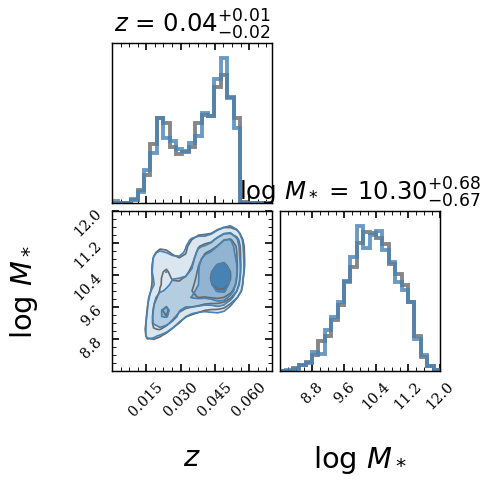

In [102]:
import matplotlib.lines as mlines

labels = [
    r'$z$',
    r'$\log\,M_*$',
    ]

# figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    X_train.cpu().numpy(),
#     fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
        range=((0, 0.07), (8, 12)),
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

figure = corner.corner(
    inverse_transform_nmf_params(NDE_theta.sample(2000), _prior_NDE).detach().cpu().numpy(),
    fig=figure,
    color='steelblue',
    labels=labels,
    bins=25,
    range=((0, 0.07), (8, 12)),
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [103]:
### No NMF transform

In [104]:
seed = 42
np.random.seed(seed)

# _prior_NDE = [[0, 0.1], [7, 13]]

_bounds = np.array([[0.03, 0.03], [10, 10]])
# _bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 30), 
#                    np.abs(np.random.normal(size=len(_bounds)) / 30)]).T
_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=10,  # 10
                                              num_bins=15,  # how smashed it is. 10
                                              hidden_features=50,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=False, 
#                                               NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )
NDE_theta.build(
    Y_train,
    X_train,
    optimizer='adam')

[ 0.03 10.  ]


In [105]:
train_loss_history = []
vali_loss_history = []
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3, #5e-4,
                                                steps_per_epoch=100,
                                                epochs=6)
for i, epoch in enumerate(range(6)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    
    t = trange(100,
           desc='Training NDE_theta using Wasserstein loss',
           unit='epochs')
    for epoch in t:
        NDE_theta.optimizer.zero_grad()
        _X_train, _X_vali = train_test_split(
            X_train.detach(), test_size=0.1, shuffle=True)
        
        loss = -NDE_theta.net.log_prob(_X_train.to('cuda')).mean()
        loss.backward()
        NDE_theta.optimizer.step()
        train_loss_history.append(loss.item())
        
        vali_loss = -NDE_theta.net.log_prob(_X_train.to('cuda')).mean()
        vali_loss_history.append(vali_loss.item())

        t.set_description(
            f'Loss = {loss.item():.3f} (train), {vali_loss.item():.3f} (vali)')
        
        scheduler.step()

    Epoch 0
    lr: 3.9999999999999996e-05


Loss = -1.168 (train), -1.376 (vali): 100%|██████████████████████████████████████████| 100/100 [00:14<00:00,  6.83epochs/s]


    Epoch 1
    lr: 0.0006079561997114258


Loss = -2.286 (train), -2.312 (vali): 100%|██████████████████████████████████████████| 100/100 [00:14<00:00,  6.80epochs/s]


    Epoch 2
    lr: 0.0009938441949208876


Loss = -2.140 (train), -2.271 (vali): 100%|██████████████████████████████████████████| 100/100 [00:14<00:00,  6.83epochs/s]


    Epoch 3
    lr: 0.0008088129289961519


Loss = -2.406 (train), -2.407 (vali): 100%|██████████████████████████████████████████| 100/100 [00:14<00:00,  6.77epochs/s]


    Epoch 4
    lr: 0.00045890866416338575


Loss = -2.418 (train), -2.418 (vali): 100%|██████████████████████████████████████████| 100/100 [00:14<00:00,  6.85epochs/s]


    Epoch 5
    lr: 0.0001309439774943247


Loss = -2.418 (train), -2.418 (vali): 100%|██████████████████████████████████████████| 100/100 [00:14<00:00,  6.75epochs/s]


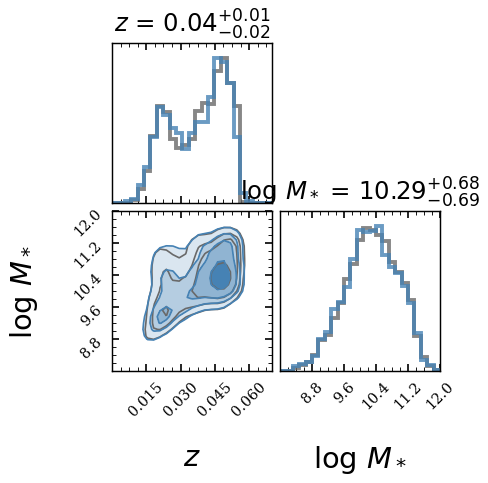

In [110]:
import matplotlib.lines as mlines

labels = [
    r'$z$',
    r'$\log\,M_*$',
    ]

# figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    X_train.cpu().numpy(),
#     fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
        range=((0, 0.07), (8, 12)),
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

figure = corner.corner(
    NDE_theta.sample(4000).detach().cpu().numpy(),
    fig=figure,
    color='steelblue',
    labels=labels,
    bins=25,
    range=((0, 0.07), (8, 12)),
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [111]:
NDE_theta.save_model('./NDE/NMF/mass_z_prior/nsa_sedflow_mass_z.pkl')

### ANPE

In [6]:
sample = np.load('./nsa_sedflow/nsa_sedflow.posterior.reorganized.npy')
sample.shape

(10000, 12)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils as Ut
from sbi import inference as Inference

In [5]:
from popsed.nde import transform_nmf_params

In [6]:
M_train = sample[:, -1:] # M_*
z_train = sample[:, -2:-1] # z

In [8]:
# M_train = transform_nmf_params(torch.Tensor(M_train), torch.Tensor([[7.5, 12.5]]))
# z_train = transform_nmf_params(torch.Tensor(z_train), torch.Tensor([[0.01, 0.06]]))

In [10]:
# plt.hist(M_train.cpu().detach().numpy())

In [ ]:
device = 'cuda'

prior_low   = [7]
prior_high  = [13]
lower_bounds = torch.tensor(prior_low).to(device)
upper_bounds = torch.tensor(prior_high).to(device)
prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=device)

anpe = Inference.SNPE(
        prior=prior, 
        density_estimator=Ut.posterior_nn('maf', hidden_features=50, num_transforms=10), 
        device=device)
anpe.append_simulations(
    M_train, #torch.as_tensor(M_train.astype(np.float32)),  # theta is m_*
    z_train) #torch.as_tensor(z_train.astype(np.float32)))  # x is z
p_x_y_estimator = anpe.train()

In [327]:
import scipy

(array([ 0.0541649 ,  1.3721775 ,  9.29830808, 24.6269752 , 18.12718702,
        15.20228234, 23.5256222 , 27.58798981, 37.26545221, 23.48951227]),
 array([0.00159219, 0.00713083, 0.01266948, 0.01820812, 0.02374676,
        0.0292854 , 0.03482405, 0.04036269, 0.04590133, 0.05143997,
        0.05697861]),
 [<matplotlib.patches.Polygon at 0x2b63cbccc9a0>])

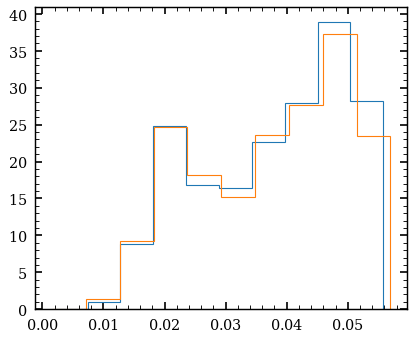

In [328]:
dist = scipy.stats.rv_histogram(np.histogram(z_train.ravel(), bins=100))
plt.hist(dist.rvs(size=2000), density=True, histtype='step')
plt.hist(z_train, density=True, histtype='step')

In [329]:
zs = dist.rvs(size=(1, 1000))

In [330]:
temp = p_x_y_estimator.sample(100, context=torch.Tensor(zs.T).to('cuda'))[:, :, 0]

In [331]:
zs = (torch.ones_like(temp) * torch.Tensor(zs.T).to('cuda')).ravel()
ms = temp.ravel()

In [332]:
temp = np.vstack([zs.detach().cpu().numpy(), ms.detach().cpu().numpy()]).T

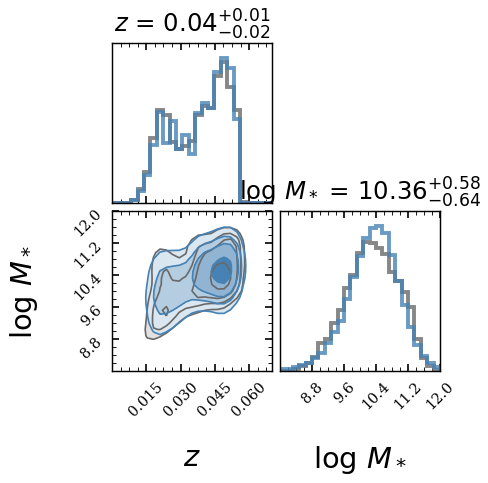

In [333]:
import matplotlib.lines as mlines

labels = [
    r'$z$',
    r'$\log\,M_*$',
    ]

# figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    X_train.cpu().numpy(),
#     fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
        range=((0, 0.07), (8, 12)),
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

figure = corner.corner(
    temp,
    fig=figure,
    color='steelblue',
    labels=labels,
    bins=25,
    range=((0, 0.07), (8, 12)),
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [334]:
with open("./NDE/NMF/mass_z_prior/anpe_mass_given_z.pkl", "wb") as handle:
    pickle.dump(p_x_y_estimator, handle)

### $P(M_*|\theta,z)$

In [46]:
M_train = torch.Tensor(sample[:, -1:]) # M_*
theta_train = torch.Tensor(sample[:, :-1]) # all other parmas. 
# Here theta is still beta 1234. We need to transform them into kappa 123
theta_train = torch.hstack([torch.Tensor(prior.FlatDirichletPrior(4).untransform(theta_train[:, :4])), 
                            theta_train[:, 4:]])

In [47]:
theta_train.shape

torch.Size([10000, 10])

In [48]:
device = 'cuda'

prior_low = [ 1.000e-10,  1.000e-10,  1.000e-10,  1.000e-10,  1.000e-02,
        -2.600e+00,  1.000e-10,  1.000e-10, -3.000e+00,  1.000e-02]
prior_high = [ 1.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  1.327e+01,
         3.000e-01,  3.000e+00,  3.000e+00,  1.000e+00,  6.000e-02]
lower_bounds = torch.tensor(prior_low).to(device)
upper_bounds = torch.tensor(prior_high).to(device)
prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=device)

anpe = Inference.SNPE(
        prior=prior, 
        density_estimator=Ut.posterior_nn('maf', hidden_features=50, num_transforms=10), 
        device=device)
anpe.append_simulations(
    M_train,
    theta_train, #torch.as_tensor(M_train.astype(np.float32)),  # theta is m_*
    ) #torch.as_tensor(z_train.astype(np.float32)))  # x is z

In [49]:
p_M_estimator = anpe.train(stop_after_epochs=50)

Neural network successfully converged after 79 epochs.


In [20]:
torch.Tensor(sample[:, :-1]).to('cuda').shape

torch.Size([10000, 11])

In [50]:
mass = p_M_estimator.sample(1, context=torch.Tensor(theta_train).to('cuda'))[:, 0].detach().cpu().numpy()

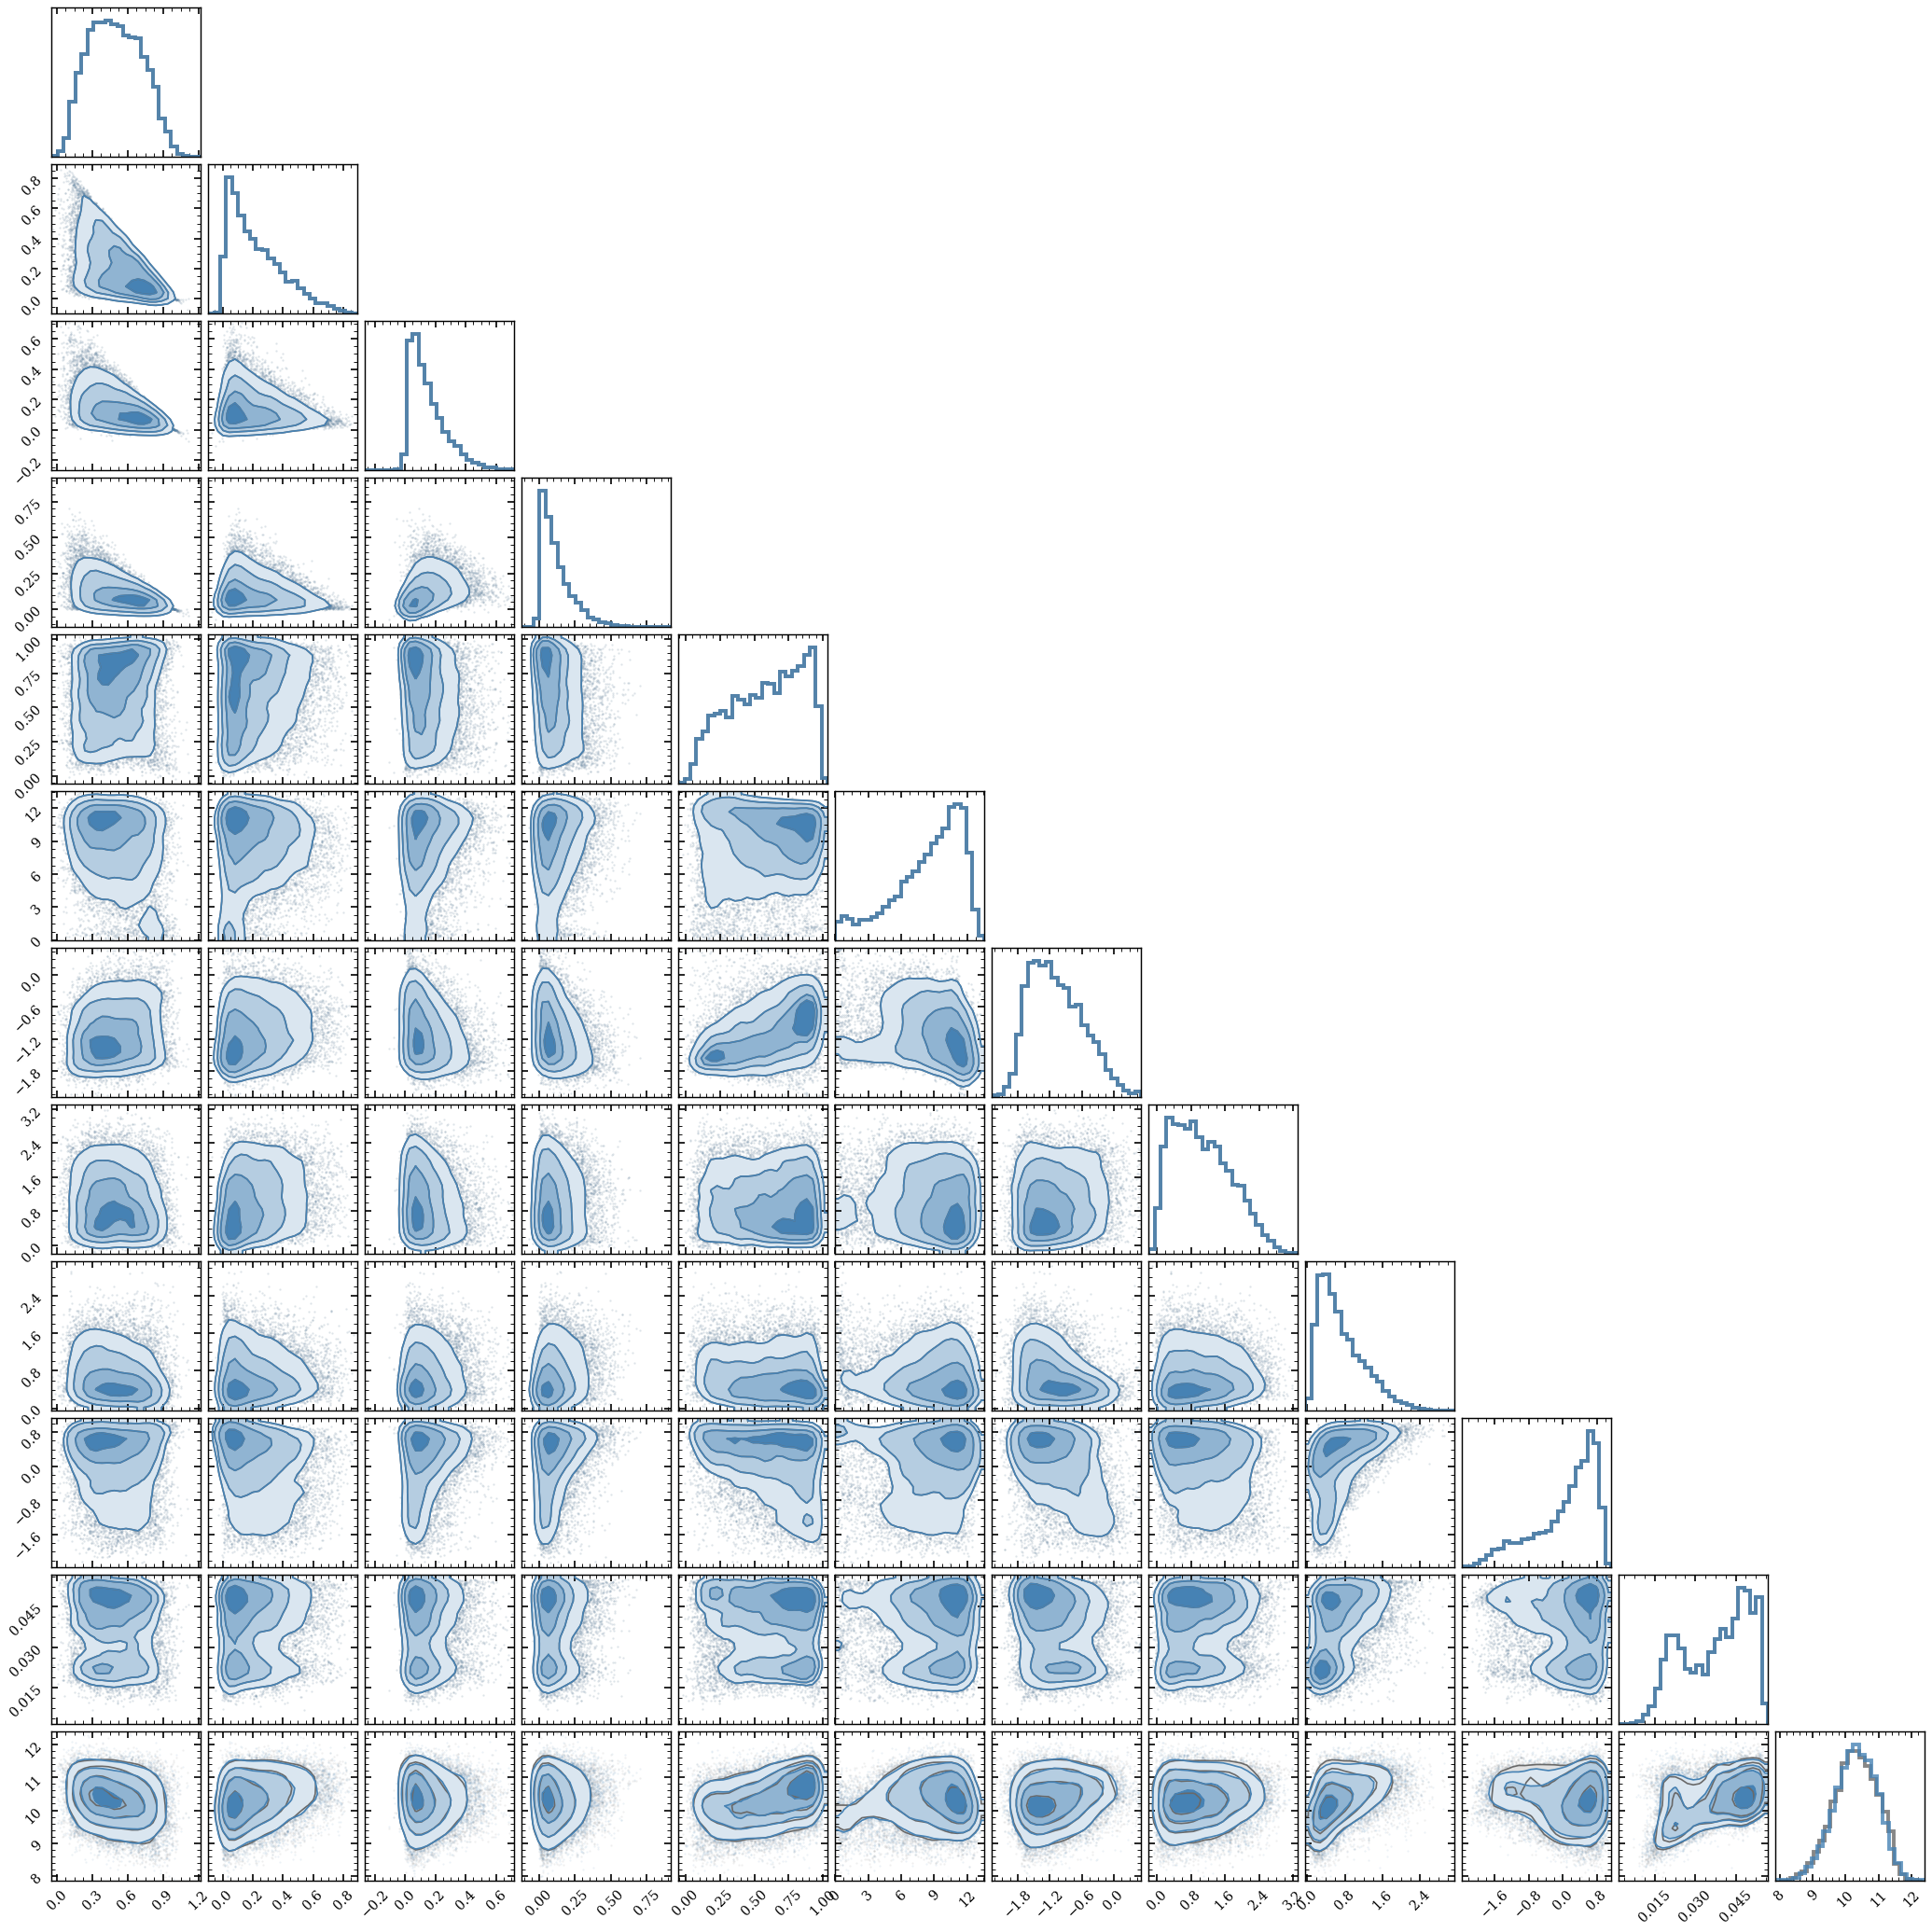

In [51]:
figure = corner.corner(
    sample,
#     fig=figure,
    color='dimgray',
#     labels=labels,
    bins=25,
#     range=NDE_theta.NDE_prior,
    smooth=1.0,
    fill_contours=True,
    show_titles=True,
    title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=True
    )

figure = corner.corner(
    np.hstack([sample[:, :-1], mass]),
    fig=figure,
    color='steelblue',
#     labels=labels,
    bins=25,
#     range=NDE_theta.NDE_prior,
    smooth=1.0,
    fill_contours=True,
    show_titles=True,
    title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=True)


In [52]:
with open("./NDE/NMF/mass_z_prior/anpe_mass_given_all_kappa.pkl", "wb") as handle:
    pickle.dump(p_M_estimator, handle)

In [ ]:
### Load ANPE 

In [335]:
with open("./NDE/NMF/mass_z_prior/anpe_mass_given_z.pkl", "rb") as handle:
    posterior = pickle.load(handle)

(array([  1.,  12.,  53., 184., 297., 236., 170.,  37.,   8.,   2.]),
 array([ 8.683648,  9.054197,  9.424747,  9.795298, 10.165847, 10.536396,
        10.906946, 11.277496, 11.648046, 12.018595, 12.389145],
       dtype=float32),
 <BarContainer object of 10 artists>)

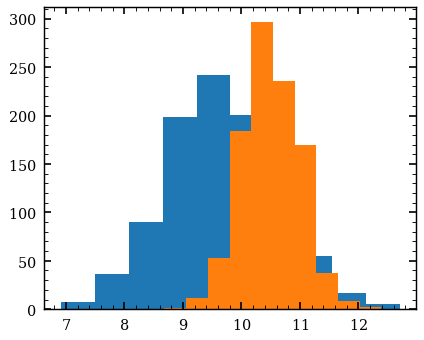

In [336]:
temp = posterior.sample(1000, context=torch.Tensor([[0.015]]).to('cuda')).detach().cpu().numpy()
plt.hist(temp.ravel())

temp = posterior.sample(1000, context=torch.Tensor([[0.045]]).to('cuda')).detach().cpu().numpy()
plt.hist(temp.ravel())